# Explicit Algorithm

In [5]:
import import_ipynb
import RSR

b = 10
y = 5
gamma = 3

def PRSR(b: int, y: int, gamma_bar: float):
    return RSR.RSR(y, gamma_bar, b, total_length= max(2*b+1, y))

PRSR(b, y, gamma)

array([9.99200722e-17, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.32826467e-01, 1.20229574e-01, 1.33588416e-01,
       1.48431573e-01, 1.64923970e-01])

# Optimization-Based Algorithm

In [6]:
import numpy as np
from scipy.optimize import linprog

def solve_rsr_two_stage(b: int, y: int, gamma_bar: float, *, method="highs"):
    """
    Solve Problem 1 then Problem 2 for RSR LPs.
    Returns: (U, pi2, beta_star, gamma_star)
      - U: sorted list of support indices
      - pi2: numpy array aligned with U, the optimal pi from Problem 2
      - beta_star: optimal beta_y from Problem 1
      - gamma_star: optimal gamma_y from Problem 2
    """
    if b <= 0:
        raise ValueError("b must be positive")
    if y <= 0:
        raise ValueError("y must be positive")
    if gamma_bar < 0:
        raise ValueError("gamma_bar must be nonnegative")

    # ---- Support U(b,y) = [b] union {y+1}, with dedup ----
    U = list(range(1, b + 1))
    U.append(y + 1)
    U = sorted(set(U))
    m = len(U)  # number of pi variables

    def cost(i: int, x: int) -> float:
        # c(i,x) = x if i > x else (b + i - 1)
        return float(x if i > x else (b + i - 1))

    def minbx(x: int) -> float:
        return float(min(b, x))

    # ======================================================
    # Problem 1: min beta
    # s.t. R(pi,x) <= gamma_bar for all x in U
    #      R(pi,y) <= beta
    #      sum pi = 1, pi >= 0, beta >= 0
    # ======================================================
    # Variables: [pi_1..pi_m, beta] => n1 = m + 1
    n1 = m + 1
    beta_idx = m

    # Objective: minimize beta
    c1 = np.zeros(n1)
    c1[beta_idx] = 1.0

    A_ub_1 = []
    b_ub_1 = []

    # R(pi,x) <= gamma_bar  => sum_i pi_i * cost(U[i], x) <= gamma_bar * min(b,x)
    for x in U:
        row = np.zeros(n1)
        for j, i in enumerate(U):
            row[j] = cost(i, x)
        A_ub_1.append(row)
        b_ub_1.append(gamma_bar * minbx(x))

    # R(pi,y) <= beta  => sum_i pi_i * cost(U[i], y) - beta * min(b,y) <= 0
    row = np.zeros(n1)
    for j, i in enumerate(U):
        row[j] = cost(i, y)
    row[beta_idx] = -minbx(y)
    A_ub_1.append(row)
    b_ub_1.append(0.0)

    A_ub_1 = np.array(A_ub_1, dtype=float)
    b_ub_1 = np.array(b_ub_1, dtype=float)

    # Equality: sum pi = 1
    A_eq_1 = np.zeros((1, n1), dtype=float)
    A_eq_1[0, :m] = 1.0
    b_eq_1 = np.array([1.0], dtype=float)

    bounds1 = [(0.0, None)] * m + [(0.0, None)]  # pi>=0, beta>=0

    res1 = linprog(c=c1, A_ub=A_ub_1, b_ub=b_ub_1, A_eq=A_eq_1, b_eq=b_eq_1,
                   bounds=bounds1, method=method)

    if not res1.success:
        raise RuntimeError(f"Problem 1 failed: {res1.message}")

    pi1 = res1.x[:m]
    beta_star = float(res1.x[beta_idx])

    # ======================================================
    # Problem 2: min gamma
    # s.t. R(pi,x) <= gamma for all x in U
    #      R(pi,y) <= beta_star
    #      sum pi = 1, pi >= 0, gamma >= 0
    # ======================================================
    # Variables: [pi_1..pi_m, gamma] => n2 = m + 1
    n2 = m + 1
    gamma_idx = m

    c2 = np.zeros(n2)
    c2[gamma_idx] = 1.0

    A_ub_2 = []
    b_ub_2 = []

    # R(pi,x) <= gamma  => sum pi*cost - gamma*min(b,x) <= 0
    for x in U:
        row = np.zeros(n2)
        for j, i in enumerate(U):
            row[j] = cost(i, x)
        row[gamma_idx] = -minbx(x)
        A_ub_2.append(row)
        b_ub_2.append(0.0)

    # R(pi,y) <= beta_star  => sum pi*cost <= beta_star * min(b,y)
    row = np.zeros(n2)
    for j, i in enumerate(U):
        row[j] = cost(i, y)
    A_ub_2.append(row)
    b_ub_2.append(beta_star * minbx(y))

    A_ub_2 = np.array(A_ub_2, dtype=float)
    b_ub_2 = np.array(b_ub_2, dtype=float)

    A_eq_2 = np.zeros((1, n2), dtype=float)
    A_eq_2[0, :m] = 1.0
    b_eq_2 = np.array([1.0], dtype=float)

    bounds2 = [(0.0, None)] * m + [(0.0, None)]  # pi>=0, gamma>=0

    res2 = linprog(c=c2, A_ub=A_ub_2, b_ub=b_ub_2, A_eq=A_eq_2, b_eq=b_eq_2,
                   bounds=bounds2, method=method)

    if not res2.success:
        raise RuntimeError(f"Problem 2 failed: {res2.message}")

    pi2 = res2.x[:m]
    gamma_star = float(res2.x[gamma_idx])

    return U, pi2, beta_star, gamma_star


def ORSR(b: int, y: int, gamma_bar: float):
    """
    Convenience wrapper: returns pi from Problem 2 as {i: pi_i} on U(b,y).
    """
    U, pi2, beta_star, gamma_star = solve_rsr_two_stage(b, y, gamma_bar)
    pi_dict = {i: float(pi2[j]) for j, i in enumerate(U)}
    return {
        "b": b,
        "y": y,
        "gamma_bar": gamma_bar,
        "U": U,
        "beta_star": beta_star,
        "gamma_star": gamma_star,
        "pi_problem2": pi_dict,
    }


# Example usage:
out = ORSR(b=10, y=5, gamma_bar=3)
print(out["U"])
print(out["beta_star"], out["gamma_star"])
print(out["pi_problem2"])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
1.0 1.6492397004980694
{1: -0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.4328264669987117, 7: 0.12022957416631078, 8: 0.133588415740343, 9: 0.1484315730448262, 10: 0.16492397004980833}


# Comparison

In [7]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# =========================
# Timing helpers
# =========================
def _time_call(fn, *args, **kwargs) -> float:
    t0 = time.perf_counter()
    fn(*args, **kwargs)
    return time.perf_counter() - t0


# =========================
# Benchmark
# =========================
def benchmark_prsr_orsr(
    bs=(10, 20, 40, 80, 160),
    gamma_start=3.0,
    gamma_end=5.0,
    gamma_step=0.5,
    repeats=1,
    warmup=0,
    progress_every=1000,
    max_points=None
) -> pd.DataFrame:
    n_steps = int(round((gamma_end - gamma_start) / gamma_step))
    gammas = [round(gamma_start + i * gamma_step, 10) for i in range(n_steps + 1)]

    rows = []
    total_points = sum((2 * b) * len(gammas) for b in bs)
    if max_points is not None:
        total_points = min(total_points, max_points)

    done = 0
    for b in bs:
        for y in range(1, 2 * b + 1):
            for gamma in gammas:
                if max_points is not None and done >= max_points:
                    break

                for _ in range(warmup):
                    PRSR(b, y, gamma)
                    ORSR(b, y, gamma)

                t_prsr = [_time_call(PRSR, b, y, gamma) for _ in range(repeats)]
                t_orsr = [_time_call(ORSR, b, y, gamma) for _ in range(repeats)]

                prsr = float(np.median(t_prsr))
                orsr = float(np.median(t_orsr))

                rows.append({
                    "b": int(b),
                    "y": int(y),
                    "gamma": float(gamma),
                    "prsr_s": prsr,
                    "orsr_s": orsr,
                    "speedup_prsr_over_orsr": (prsr / orsr) if (orsr > 0 and np.isfinite(orsr)) else np.inf,
                })

                done += 1
                if progress_every and done % progress_every == 0:
                    print(f"Progress: {done}/{total_points}")

            if max_points is not None and done >= max_points:
                break
        if max_points is not None and done >= max_points:
            break

    return pd.DataFrame(rows)


# =========================
# Cleaning utilities
# =========================
def _clean_runtime_series(s: pd.Series) -> pd.Series:
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    s = s[s >= 0]
    return s


# =========================
# Stats
# =========================
def runtime_stats(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for b in sorted(df["b"].unique()):
        sub = df[df["b"] == b]

        for algo, col in [("PRSR", "prsr_s"), ("ORSR", "orsr_s")]:
            s = _clean_runtime_series(sub[col])
            rows.append({
                "b": int(b),
                "algo": algo,
                "mean": float(s.mean()),
                "q25": float(s.quantile(0.25)),
                "q75": float(s.quantile(0.75)),
                "median": float(s.median()),
                "n": int(len(s)),
            })

    return pd.DataFrame(rows)


def speedup_summary(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.assign(speedup=df["speedup_prsr_over_orsr"].replace([np.inf, -np.inf], np.nan))
          .dropna(subset=["speedup"])
          .groupby("b")["speedup"]
          .agg(
              mean="mean",
              median="median",
              q25=lambda x: x.quantile(0.25),
              q75=lambda x: x.quantile(0.75),
              n="count",
          )
          .reset_index()
    )


# =========================
# Plot helpers (your style)
# =========================
def get_mean_iqr_runtime(stats_df: pd.DataFrame, algo: str):
    sub = stats_df[stats_df["algo"] == algo].sort_values("b")
    return (
        sub["mean"].to_numpy(dtype=float),
        sub["q25"].to_numpy(dtype=float),
        sub["q75"].to_numpy(dtype=float),
    )


def draw_mean_with_iqr(ax, x, mean, q25, q75, width, color, label=None):
    ax.bar(x, mean, width=width, color=color, label=label, zorder=2)

    ax.vlines(x, q25, q75, color="black", linewidth=2.0, zorder=3)

    cap = width * 0.35
    ax.hlines(q25, x - cap, x + cap, color="black", linewidth=2.0, zorder=3)
    ax.hlines(q75, x - cap, x + cap, color="black", linewidth=2.0, zorder=3)


# =========================
# One-figure plot (log10)
# =========================
def plot_runtime_log10_one_figure(
    stats_df: pd.DataFrame,
    bs=(10, 20, 40, 80, 160),
    out_pdf="runtime_log10_explicit_vs_optimization.pdf",
    out_png="runtime_log10_explicit_vs_optimization.png",
):
    # Filter and enforce b order
    stats_df = stats_df[stats_df["b"].isin(bs)].copy()
    stats_df["b"] = pd.Categorical(stats_df["b"], categories=list(bs), ordered=True)
    stats_df = stats_df.sort_values(["b", "algo"])

    display_names = {"PRSR": "Explicit", "ORSR": "Optimization-Based"}
    colors = {"PRSR": "#1f77b4", "ORSR": "#d62728"}

    plt.rcParams.update({
        "font.size": 20,
        "axes.labelsize": 20,
        "axes.titlesize": 20,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "legend.fontsize": 20,
    })

    x = np.arange(len(bs))
    bar_width = 0.32

    fig, ax = plt.subplots(figsize=(10.8, 4.8))
    ax.set_yscale("log", base=10)

    # ---- Bars + IQR ----
    for i, algo in enumerate(["PRSR", "ORSR"]):
        offset = (i - 0.5) * bar_width
        mean, q25, q75 = get_mean_iqr_runtime(stats_df, algo)

        eps = 1e-12
        mean = np.maximum(mean, eps)
        q25 = np.maximum(q25, eps)
        q75 = np.maximum(q75, eps)

        draw_mean_with_iqr(
            ax,
            x + offset,
            mean, q25, q75,
            bar_width,
            colors[algo],
            label=display_names[algo]
        )

    # ---- Axes labels ----
    ax.set_xticks(x)
    ax.set_xticklabels([str(b) for b in bs])
    ax.set_xlabel("b")
    ax.set_ylabel("Runtime (seconds)")

    # ---- Force log ticks (include 1e-1 and 1e-4) ----
    yticks = [1e-4, 1e-3, 1e-2, 1e-1]
    ax.set_yticks(yticks)
    ax.set_yticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

    # ---- No gridlines ----
    ax.grid(False)

    # ---- Clean spines ----
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # ---- Legend ----
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(0.02, 0.98),
        frameon=True,
        fancybox=True,
        framealpha=0.9,
        borderpad=0.6
    )

    plt.tight_layout()
    fig.savefig(out_pdf, bbox_inches="tight")
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()

Progress: 1000/3100
Progress: 2000/3100
Progress: 3000/3100

=== Runtime stats (mean / q25 / q75 / median) ===
  b algo     mean      q25      q75   median    n
 10 PRSR 0.000142 0.000120 0.000156 0.000142  100
 10 ORSR 0.001148 0.001102 0.001177 0.001133  100
 20 PRSR 0.000308 0.000230 0.000388 0.000329  200
 20 ORSR 0.001597 0.001516 0.001622 0.001574  200
 40 PRSR 0.000864 0.000474 0.001242 0.001006  400
 40 ORSR 0.003176 0.002970 0.003311 0.003138  400
 80 PRSR 0.002816 0.001301 0.004331 0.003529  800
 80 ORSR 0.008752 0.008256 0.008987 0.008735  800
160 PRSR 0.010246 0.004248 0.016440 0.013649 1600
160 ORSR 0.034687 0.030452 0.037665 0.035664 1600

=== Speedup summary (PRSR / ORSR) ===
  b     mean   median      q25      q75    n
 10 0.123667 0.122389 0.106450 0.135970  100
 20 0.193156 0.204029 0.148697 0.238619  200
 40 0.267172 0.284584 0.162982 0.381266  400
 80 0.314047 0.364707 0.158382 0.475862  800
160 0.281109 0.341956 0.142315 0.437623 1600


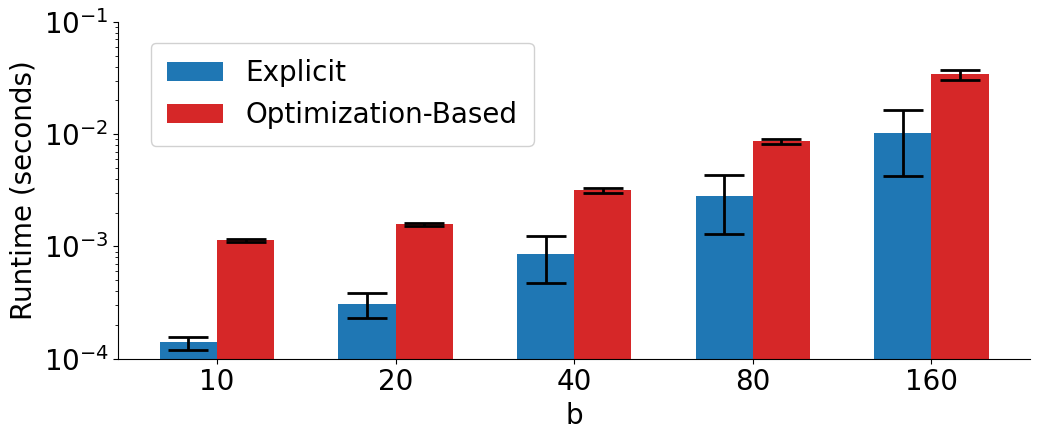


Saved:
  runtime_prsr_vs_orsr_raw.csv
  runtime_prsr_vs_orsr_stats.csv
  runtime_prsr_vs_orsr_stats.csv
  runtime_log10_explicit_vs_optimization.pdf
  runtime_log10_explicit_vs_optimization.png


In [8]:
if __name__ == "__main__":
    bs = (10, 20, 40, 80, 160)

    df = benchmark_prsr_orsr(
        bs=bs,
        gamma_start=3.0,
        gamma_end=5.0,
        gamma_step=0.5,
        repeats=5,
        warmup=0,
        progress_every=1000
    )

    stats = runtime_stats(df)
    spd = speedup_summary(df)

    print("\n=== Runtime stats (mean / q25 / q75 / median) ===")
    print(stats.to_string(index=False))

    print("\n=== Speedup summary (PRSR / ORSR) ===")
    print(spd.to_string(index=False))

    # One nice figure
    plot_runtime_log10_one_figure(stats, bs=bs)

    # Save data
    df.to_csv("runtime_orsr_vs_orsr_raw.csv", index=False)
    stats.to_csv("runtime_prsr_vs_orsr_stats.csv", index=False)
    spd.to_csv("runtime_prsr_vs_orsr_speedup.csv", index=False)

    print("\nSaved:")
    print("  runtime_prsr_vs_orsr_raw.csv")
    print("  runtime_prsr_vs_orsr_stats.csv")
    print("  runtime_prsr_vs_orsr_stats.csv")
    print("  runtime_log10_explicit_vs_optimization.pdf")
    print("  runtime_log10_explicit_vs_optimization.png")